# 2025 CITS4012 Project 2

## 1. Preprocessing

### 1.1. Import Libraries
Libraries are imported for the entire project.

*Note: Just add to this list as needed*

In [ ]:
%pip install gensim
import gensim.downloader as api

# from pydrive2.auth import GoogleAuth
# from pydrive2.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import time
import torch
import spacy
import re

torch.manual_seed(42)
random.seed(42)

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 1.2. Retrieve Data
First, we need to retrieve the train/val/test datafiles from the Google Drive.

In [ ]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
# train_fileid = "1YEOo5vd8DXXUCf1FXCR1D3PxWR9XxQKv"
# val_fileid = "15FEgtzzTVDMQcNVMgwIwqoAJeF9vmtrX"
# test_fileid = "179nwaOvdkZ3ogsBaTSJvpZEIjq20uiG-"

# train_file = drive.CreateFile({'id': train_fileid})
# val_file = drive.CreateFile({'id': val_fileid})
# test_file = drive.CreateFile({'id': test_fileid})

# train_file.GetContentFile('train.json')
# val_file.GetContentFile('val.json')
# test_file.GetContentFile('test.json')

### 1.3. Read in the Data
We now read in each dataset, splitting the input data and target data. The data shapes and a sample of the training data are shown below.

In [67]:
train = pd.read_json('train.json')
X_train = train[['premise', 'hypothesis']]
y_train = train['label']

val = pd.read_json('val.json')
X_val = val[['premise', 'hypothesis']]
y_val = val['label']

test = pd.read_json('test.json')
X_test = test[['premise', 'hypothesis']]
y_test = test['label']

print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
display(train)

Train shape: (23088, 2)
Val shape: (1304, 2)
Test shape: (2126, 2)


,premise,hypothesis,label
0,Pluto rotates once on its axis every 6.39 Eart...,Earth rotates on its axis once times in one day.,neutral
1,---Glenn =====================================...,Earth rotates on its axis once times in one day.,entails
2,geysers - periodic gush of hot water at the su...,The surface of the sun is much hotter than alm...,neutral
3,Facts: Liquid water droplets can be changed in...,Evaporation is responsible for changing liquid...,entails
4,"By comparison, the earth rotates on its axis o...",Earth rotates on its axis once times in one day.,entails
...,...,...,...
23083,"which is not only the motion of our bodies, bu...",Work is done only if a force is exerted in the...,neutral
23084,"The Red Star, that celestial curse whose eccen...",Red-shift refers to a shift toward red in the ...,neutral
23085,The lines in the spectrum of a luminous body s...,Red-shift refers to a shift toward red in the ...,entails
23086,The radial velocity of a star away from or tow...,Red-shift refers to a shift toward red in the ...,entails


### 1.4. Data preprocessing
As seen above, the data contains characters that requires cleaning before passing it to the model.

The preprocessing pipeline is as follows:
- Sentences are tokenised using SpaCy.
- A vocabulary list is constructed, including a padding and out-of-vocabulary tag.
- A GloVe Embedding model is loaded, pretrained on twitter.
- Tokenised sentences are converted to an indexed list of words, padded to the maximum size of the premise and hypothesis, respectively.

The labels are also converted to 0 or 1 (0 = neutral, 1 = entails).

#### 1.4.1. SpaCy Tokenisation
We tokenise the premises and hypotheses for the training set - removing all non alphanumeric characters and converting words to lower case.

In [68]:
#### 1.4.1. SpaCy Tokenisation
# We tokenise all datasets - removing all non alphanumeric characters and converting words to lower case.

spacy.cli.download('en_core_web_sm')
tokeniser = spacy.load('en_core_web_sm')

def tokenize_dataset(X_data, dataset_name="dataset"):
    """
    Tokenize premise and hypothesis columns using SpaCy.
    
    Args:
        X_data: DataFrame with 'premise' and 'hypothesis' columns
        dataset_name: Name for logging purposes
    
    Returns:
        Tokenized DataFrame (copy)
    """
    print(f"Tokenizing {dataset_name}...")
    
    X_data = X_data.copy()  # Avoid pandas warnings
    
    # Tokenize premises
    premise_list = X_data['premise'].tolist()
    prem_tokens_list = list(tokeniser.pipe(premise_list, batch_size=64))
    X_data.loc[:, "premise"] = [
        [token.text.lower() for token in tokens if re.match(r'^\w+$', token.text)] 
        for tokens in prem_tokens_list
    ]
    
    # Tokenize hypotheses
    hypothesis_list = X_data['hypothesis'].tolist()
    hyp_tokens_list = list(tokeniser.pipe(hypothesis_list, batch_size=64))
    X_data.loc[:, "hypothesis"] = [
        [token.text.lower() for token in tokens if re.match(r'^\w+$', token.text)] 
        for tokens in hyp_tokens_list
    ]
    
    print(f"✓ {dataset_name} tokenized")
    return X_data

# Tokenize all datasets
X_train = tokenize_dataset(X_train, "Training set")
X_val = tokenize_dataset(X_val, "Validation set")
X_test = tokenize_dataset(X_test, "Test set")

print("\nSample tokenized data:")
display(X_train.head())

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.9 MB/s eta 0:00:00a 0:00:01



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Tokenizing Training set...
✓ Training set tokenized
Tokenizing Validation set...
✓ Validation set tokenized
Tokenizing Test set...
✓ Test set tokenized

Sample tokenized data:


,premise,hypothesis
0,"[pluto, rotates, once, on, its, axis, every, e...","[earth, rotates, on, its, axis, once, times, i..."
1,"[once, per, day, the, earth, rotates, about, i...","[earth, rotates, on, its, axis, once, times, i..."
2,"[geysers, periodic, gush, of, hot, water, at, ...","[the, surface, of, the, sun, is, much, hotter,..."
3,"[facts, liquid, water, droplets, can, be, chan...","[evaporation, is, responsible, for, changing, ..."
4,"[by, comparison, the, earth, rotates, on, its,...","[earth, rotates, on, its, axis, once, times, i..."


#### 1.4.2. Vocabulary Construction

In [69]:
vocab_set = set([])
for tokens in X_train['premise']:
    for token in tokens:
        vocab_set.add(token)
for tokens in X_train['hypothesis']:
    for token in tokens:
        vocab_set.add(token)

# Convert the set to a list
vocab = ['[PAD]', '[OOV]']
vocab.extend(list(vocab_set))

wordindexes = {word: i for i, word in enumerate(vocab)}

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 20127


#### 1.4.3 Embedding Table Creation
We load the GloVe embeddings, and then for each word in the training set vocabulary, we add the embedding to our lookup table. If a word in the vocabulary does not exist in the GloVe embeddings, it is embedded as zeros.

In [70]:
try:
    glove_embeddings = api.load("glove-twitter-100")
    emb_dim = glove_embeddings.vector_size
    def get_vec(word):
        return glove_embeddings[word] if word in glove_embeddings else np.zeros(emb_dim)
    emb_table = np.array([get_vec(word) for word in vocab])
    del glove_embeddings
except Exception as e:
    print("Network/cache issue loading GloVe (glove-twitter-100). Using deterministic random embeddings instead.\n", e)
    emb_dim = 100  # match glove-twitter-100 dimension
    rng = np.random.default_rng(42)
    emb_table = rng.normal(0.0, 1.0, size=(len(vocab), emb_dim)).astype(np.float32)

emb_table.shape

Network/cache issue loading GloVe (glove-twitter-100). Using deterministic random embeddings instead.
 unable to read local cache '/Users/mahitgupta/gensim-data/information.json' during fallback, connect to the Internet and retry


(20127, 100)

Later, we can now create an Embedding object that can be used to lookup the embeddings for any given word. This saves us from having to load the entire vocabulary embeddings at once during training.

### 1.5. Data visualisation
We will visualise the data to observe any patterns that we should be aware of before preprocessing and training.

First, lets observe the class balance for the train/val/test sets.

In [71]:
print(
    "Training set distribution:\n"
    f"Neutral = {round(y_train[y_train == 'neutral'].shape[0] / y_train.shape[0],2)}\n"
    f"Entails = {round(y_train[y_train == 'entails'].shape[0] / y_train.shape[0],2)}\n"
    "Validation set distribution:\n"
    f"Neutral = {round(y_val[y_val == 'neutral'].shape[0] / y_val.shape[0],2)}\n"
    f"Entails = {round(y_val[y_val == 'entails'].shape[0] / y_val.shape[0],2)}\n"
    "Testing set distribution:\n"
    f"Neutral = {round(y_test[y_test == 'neutral'].shape[0] / y_test.shape[0],2)}\n"
    f"Entails = {round(y_test[y_test == 'entails'].shape[0] / y_test.shape[0],2)}\n"
)

Training set distribution:
Neutral = 0.63
Entails = 0.37
Validation set distribution:
Neutral = 0.5
Entails = 0.5
Testing set distribution:
Neutral = 0.6
Entails = 0.4



The training set is strongly skewed towards neutral samples - this will have an impact on training.

Now, we will observe the distribution of the token lengths of the premises and hypotheses of the train and validation sets.

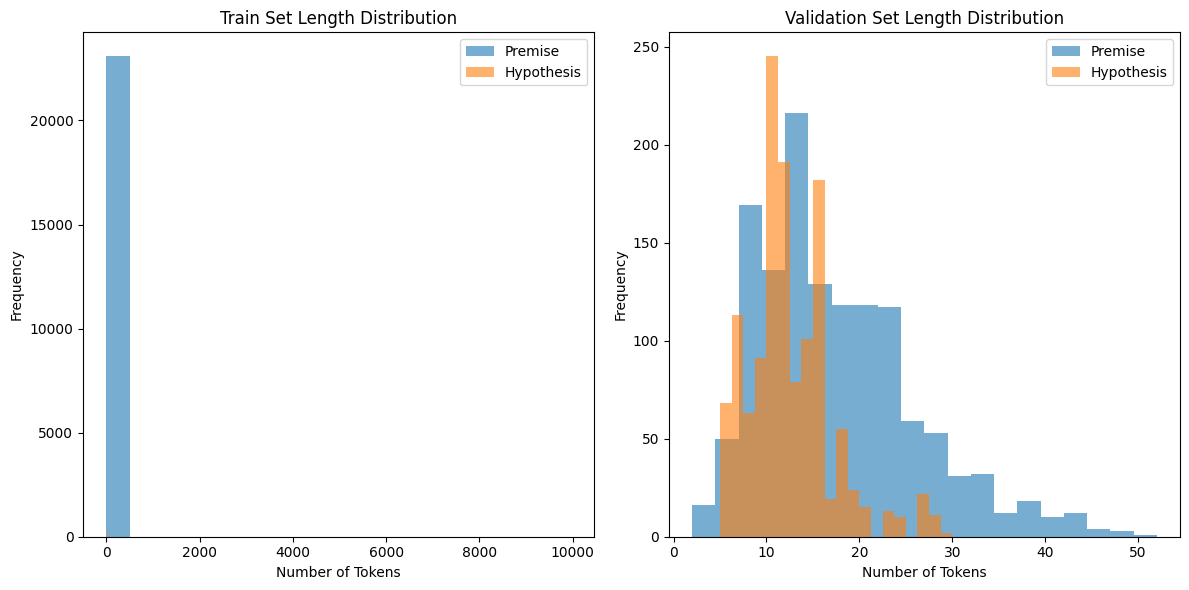

In [72]:
train_prem_lengths = [len(premise) for premise in X_train['premise']]
train_hyp_lengths = [len(hypothesis) for hypothesis in X_train['hypothesis']]

val_prem_lengths = [len(premise) for premise in X_val['premise']]
val_hyp_lengths = [len(hypothesis) for hypothesis in X_val['hypothesis']]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train set
axs[0].hist(train_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[0].hist(train_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[0].set_title("Train Set Length Distribution")
axs[0].set_xlabel("Number of Tokens")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# Validation set
axs[1].hist(val_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[1].hist(val_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[1].set_title("Validation Set Length Distribution")
axs[1].set_xlabel("Number of Tokens")
axs[1].set_ylabel("Frequency")
axs[1].legend()

plt.tight_layout()
plt.show()

This indicates there are some outliers in the train set. Reviewing the ten largest premises in the training set reveals there are some abnormally large instances:

In [73]:
largest_prem = sorted(range(len(train_prem_lengths)), key=lambda i: train_prem_lengths[i], reverse=True)[:10]
print([train_prem_lengths[i] for i in largest_prem])

[9966, 5829, 2249, 1154, 938, 705, 594, 550, 314, 111]


Removing these outliers from the training set, we get a nicer looking plot:

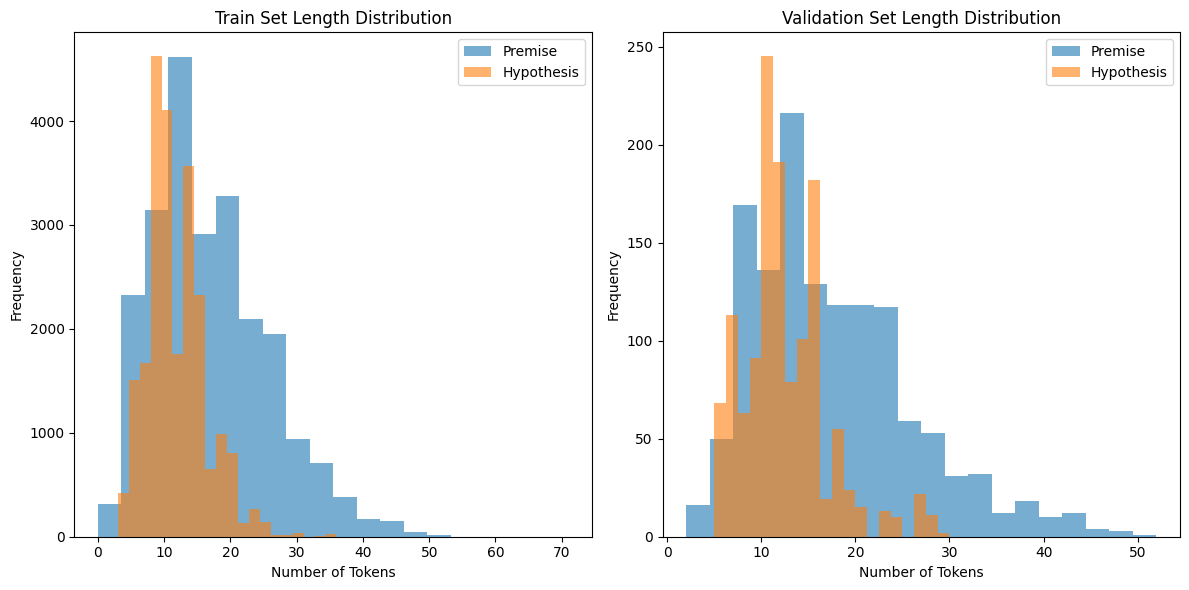

In [74]:
X_train = X_train.drop(X_train.index[largest_prem])
y_train = y_train.drop(y_train.index[largest_prem])

train_prem_lengths = [len(premise) for premise in X_train['premise']]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train set
axs[0].hist(train_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[0].hist(train_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[0].set_title("Train Set Length Distribution")
axs[0].set_xlabel("Number of Tokens")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# Validation set
axs[1].hist(val_prem_lengths, bins=20, alpha=0.6, label='Premise')
axs[1].hist(val_hyp_lengths, bins=20, alpha=0.6, label='Hypothesis')
axs[1].set_title("Validation Set Length Distribution")
axs[1].set_xlabel("Number of Tokens")
axs[1].set_ylabel("Frequency")
axs[1].legend()

plt.tight_layout()
plt.show()

### 1.6. Dataset Formation
Now we create the training dataset. The tokenised premise and hypothesis sentences are encoded to be the index that corresponds to the word embedding in the embeddings table. Each sentence is then padded to be the same length as the longest respective premise or hypothesis.

In [75]:
def encode_sentences(sentences):
    encoded_sentences = []
    for sentence in sentences:
        encoded_sentences.append([wordindexes[word] if word in wordindexes else wordindexes['[OOV]'] for word in sentence])
    return encoded_sentences

def pad_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_length:
            padded_seq = seq + [wordindexes['[PAD]']] * (max_length - len(seq))
        else:
            padded_seq = seq[:max_length]
        padded_sequences.append(padded_seq)
    return padded_sequences

max_prem = max(len(sentence) for sentence in X_train['premise'])
max_hyp = max(len(sentence) for sentence in X_train['hypothesis'])
encoded_prem_train = pad_sequences(encode_sentences(X_train['premise']), max_prem)
encoded_hyp_train = pad_sequences(encode_sentences(X_train['hypothesis']), max_hyp)

encoded_prem_val = pad_sequences(encode_sentences(X_val['premise']), max_prem)
encoded_hyp_val = pad_sequences(encode_sentences(X_val['hypothesis']), max_hyp)

The labels are now converted to 0 for neutral, and 1 for entails.

In [76]:
y_train = y_train.map({'neutral': 0, 'entails': 1})
y_val = y_val.map({'neutral': 0, 'entails': 1})
y_test = y_test.map({'neutral': 0, 'entails': 1})

Now we can create the dataset and data loaders for the train and validation set. To reduce the impact of the class imbalance in the train set, the number of neutral samples is reduced to the number of entails samples.

In [77]:
batch_size = 16

train_data = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_train), torch.tensor(encoded_hyp_train), torch.tensor(y_train.values))

neutral_indices = [i for i, label in enumerate(y_train.values) if label == 0]
entails_indices = [i for i, label in enumerate(y_train.values) if label == 1]

min_samplesize = min(len(neutral_indices), len(entails_indices))

# random sample from training set to make sure both are the same size
neutral_indices = random.sample(neutral_indices, min_samplesize)
entails_indices = random.sample(entails_indices, min_samplesize)

# combine the indices
train_indices = neutral_indices + entails_indices
random.shuffle(train_indices)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)

val_data = torch.utils.data.TensorDataset(torch.tensor(encoded_prem_val), torch.tensor(encoded_hyp_val), torch.tensor(y_val.values))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

### 1.7 Test Dataset
Finally, we create the test dataset in a similar way the training and validation sets are created.

In [78]:
### 1.7 Test Dataset
# Use the same max lengths from training (already calculated in 1.6)
encoded_prem_test = pad_sequences(encode_sentences(X_test['premise']), max_prem)
encoded_hyp_test = pad_sequences(encode_sentences(X_test['hypothesis']), max_hyp)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(encoded_prem_test), 
    torch.tensor(encoded_hyp_test), 
    torch.tensor(y_test.values)
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

print(f"✓ Test set ready: {len(test_dataset)} samples")
print(f"  Premise shape: {encoded_prem_test[0][:5]}... (length: {max_prem})")
print(f"  Hypothesis shape: {encoded_hyp_test[0][:5]}... (length: {max_hyp})")

✓ Test set ready: 2126 samples
  Premise shape: [15888, 13121, 15446, 7545, 13978]... (length: 71)
  Hypothesis shape: [17640, 523, 12566, 247, 523]... (length: 36)


In [ ]:
# Dataloader sample usage
# for i, batch in enumerate(train_loader):
    # i = batch number
    # premises   = batch[0]
    # hypotheses = batch[1]
    # labels     = batch[2]

# 2 Implemenation
## 2.1. Transformer Model
We will use a pre-trained GloVe embedding model to initialise the embeddings for the model.

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.optim.lr_scheduler import (
    ReduceLROnPlateau,
    StepLR,
    CosineAnnealingLR
)


# Copy PositionalEncoding from Lab 8
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class NLITransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim, nhead, nhid, nlayers, emb_table, dropout=0.3, freeze_embeddings=True):
        super(NLITransformer, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        if emb_table is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(emb_table))
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False
        
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        
        # Attention-weighted pooling
        self.attention_weights = nn.Linear(emb_dim, 1)
        
        # Classifier
        self.fc = nn.Linear(emb_dim, 2)
        self.dropout = nn.Dropout(dropout)
        
    def attention_pooling(self, encoder_output, mask=None):
        """
        Apply attention-weighted pooling
        encoder_output: (batch_size, seq_len, emb_dim)
        mask: (batch_size, seq_len) - True for padding positions
        Returns: (batch_size, emb_dim)
        """
        # Calculate attention scores for each token
        attention_scores = self.attention_weights(encoder_output)  # (batch, seq_len, 1)
        attention_scores = attention_scores.squeeze(-1)  # (batch, seq_len)
        
        # Mask padding tokens (set to very negative value before softmax)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask, -1e9)
        
        # Apply softmax to get weights
        attention_weights = torch.softmax(attention_scores, dim=1)  # (batch, seq_len)
        
        # Weighted sum of encoder outputs
        weighted_output = torch.bmm(
            attention_weights.unsqueeze(1),  # (batch, 1, seq_len)
            encoder_output  # (batch, seq_len, emb_dim)
        ).squeeze(1)  # (batch, emb_dim)
        
        return weighted_output
    
    def forward(self, premise, hypothesis):
        # Create padding masks
        premise_mask = (premise == 0)  # Assuming 0 is padding idx
        hypothesis_mask = (hypothesis == 0)
        
        # Embed
        premise_emb = self.embedding(premise)
        hypothesis_emb = self.embedding(hypothesis)
        
        # Concatenate premise and hypothesis
        combined = torch.cat([premise_emb, hypothesis_emb], dim=1)
        combined_mask = torch.cat([premise_mask, hypothesis_mask], dim=1)
        
        # Transform
        encoded = self.transformer_encoder(combined, src_key_padding_mask=combined_mask)
        
        # Attention-weighted pooling instead of mean
        pooled = self.attention_pooling(encoded, mask=combined_mask)
        
        # Classify
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        
        return logits

In [84]:
# Test the model with dummy data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
vocab_size = len(vocab)
emb_dim = 100
nhead = 4
nhid = 256
nlayers = 2
dropout = 0.3

# Initialize model
model = NLITransformer(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    nhead=nhead,
    nhid=nhid,
    nlayers=nlayers,
    emb_table=emb_table,
    dropout=dropout,
    freeze_embeddings=True
).to(device)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test with a batch from your data
for batch in train_loader:
    premises, hypotheses, labels = batch
    premises = premises.to(device)
    hypotheses = hypotheses.to(device)
    
    # Forward pass
    logits = model(premises, hypotheses)
    print(f"\n✓ Forward pass successful!")
    print(f"  Input shapes: premise={premises.shape}, hypothesis={hypotheses.shape}")
    print(f"  Output shape: {logits.shape}")
    print(f"  Sample output: {logits[0]}")
    break  # Just test one batch

Total parameters: 2,197,715
Trainable parameters: 185,015

✓ Forward pass successful!
  Input shapes: premise=torch.Size([16, 71]), hypothesis=torch.Size([16, 36])
  Output shape: torch.Size([16, 2])
  Sample output: tensor([-0.0189,  0.0079], grad_fn=<SelectBackward0>)


In [87]:
class NLITransformerCrossAttention(nn.Module):
    def __init__(self, vocab_size, emb_dim, nhead, nhid, nlayers, emb_table, dropout=0.3, freeze_embeddings=True):
        super(NLITransformerCrossAttention, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        if emb_table is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(emb_table))
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False
        
        # Separate encoders for premise and hypothesis
        encoder_layers_premise = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True
        )
        self.premise_encoder = nn.TransformerEncoder(encoder_layers_premise, nlayers)
        
        encoder_layers_hypothesis = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True
        )
        self.hypothesis_encoder = nn.TransformerEncoder(encoder_layers_hypothesis, nlayers)
        
        # Cross-attention layer
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=emb_dim,
            num_heads=nhead,
            dropout=dropout,
            batch_first=True
        )
        
        # Attention-weighted pooling for both premise and hypothesis
        self.premise_attention_weights = nn.Linear(emb_dim, 1)
        self.hypothesis_attention_weights = nn.Linear(emb_dim, 1)
        
        # Classifier
        self.fc = nn.Linear(emb_dim * 2, 2)  # Concatenate both representations
        self.dropout = nn.Dropout(dropout)
        
    def attention_pooling(self, encoder_output, attention_layer, mask=None):
        """
        Apply attention-weighted pooling
        encoder_output: (batch_size, seq_len, emb_dim)
        attention_layer: Linear layer for computing attention scores
        mask: (batch_size, seq_len) - True for padding positions
        Returns: (batch_size, emb_dim)
        """
        # Calculate attention scores
        attention_scores = attention_layer(encoder_output)  # (batch, seq_len, 1)
        attention_scores = attention_scores.squeeze(-1)  # (batch, seq_len)
        
        # Mask padding tokens
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask, -1e9)
        
        # Apply softmax
        attention_weights = torch.softmax(attention_scores, dim=1)  # (batch, seq_len)
        
        # Weighted sum
        weighted_output = torch.bmm(
            attention_weights.unsqueeze(1),
            encoder_output
        ).squeeze(1)
        
        return weighted_output
    
    def forward(self, premise, hypothesis):
        # Create padding masks
        premise_mask = (premise == 0)
        hypothesis_mask = (hypothesis == 0)
        
        # Embed
        premise_emb = self.embedding(premise)
        hypothesis_emb = self.embedding(hypothesis)
        
        # Encode separately
        premise_encoded = self.premise_encoder(premise_emb, src_key_padding_mask=premise_mask)
        hypothesis_encoded = self.hypothesis_encoder(hypothesis_emb, src_key_padding_mask=hypothesis_mask)
        
        # Cross-attention: hypothesis attends to premise
        cross_attended, _ = self.cross_attention(
            query=hypothesis_encoded,
            key=premise_encoded,
            value=premise_encoded,
            key_padding_mask=premise_mask
        )
        
        # Attention-weighted pooling for both
        premise_pooled = self.attention_pooling(
            premise_encoded, 
            self.premise_attention_weights, 
            mask=premise_mask
        )
        hypothesis_pooled = self.attention_pooling(
            cross_attended, 
            self.hypothesis_attention_weights, 
            mask=hypothesis_mask
        )
        
        # Concatenate both representations
        combined = torch.cat([premise_pooled, hypothesis_pooled], dim=1)
        
        # Classify
        combined = self.dropout(combined)
        logits = self.fc(combined)
        
        return logits

In [89]:
# Test cross-attention model
model_cross = NLITransformerCrossAttention(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    nhead=4,
    nhid=256,
    nlayers=2,
    emb_table=emb_table,
    dropout=0.2,
    freeze_embeddings=True
).to(device)

print(f"Total parameters: {sum(p.numel() for p in model_cross.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_cross.parameters() if p.requires_grad):,}")

# Test forward pass
for batch in train_loader:
    premises, hypotheses, labels = batch
    premises = premises.to(device)
    hypotheses = hypotheses.to(device)
    
    logits = model_cross(premises, hypotheses)
    print(f"\n✓ Cross-Attention forward pass successful!")
    print(f"  Input shapes: premise={premises.shape}, hypothesis={hypotheses.shape}")
    print(f"  Output shape: {logits.shape}")
    print(f"  Sample output: {logits[0]}")
    break

Total parameters: 2,423,128
Trainable parameters: 410,428

✓ Cross-Attention forward pass successful!
  Input shapes: premise=torch.Size([16, 71]), hypothesis=torch.Size([16, 36])
  Output shape: torch.Size([16, 2])
  Sample output: tensor([-0.1023, -0.1129], grad_fn=<SelectBackward0>)


In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score

# ============================================================================
# TRAINING AND EVALUATION FUNCTIONS
# ============================================================================

def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch with gradient clipping"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for premises, hypotheses, labels in train_loader:
        premises = premises.to(device)
        hypotheses = hypotheses.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(premises, hypotheses)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion, device):
    """Evaluate the model on validation or test set"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for premises, hypotheses, labels in data_loader:
            premises = premises.to(device)
            hypotheses = hypotheses.to(device)
            labels = labels.to(device)
            
            logits = model(premises, hypotheses)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


# ============================================================================
# ABLATION STUDY
# ============================================================================

# Define ablation configurations
ablation_configs = {
    'variant_1_self_attn': {
        'model_class': NLITransformer,
        'description': 'Concatenation + Self-Attention + Attention Pooling',
        'nhead': 4,
        'nlayers': 2
    },
    'variant_2_cross_attn': {
        'model_class': NLITransformerCrossAttention,
        'description': 'Separate Encoding + Cross-Attention + Attention Pooling',
        'nhead': 4,
        'nlayers': 2
    },
}

# Storage for all results
ablation_results = {}

print("="*70)
print("ATTENTION MECHANISM ABLATION STUDY WITH ATTENTION POOLING")
print("="*70)

for variant_name, config in ablation_configs.items():
    print(f"\n{'='*70}")
    print(f"Training: {variant_name}")
    print(f"Description: {config['description']}")
    print(f"Config: nhead={config['nhead']}, nlayers={config['nlayers']}")
    print(f"{'='*70}\n")
    
    # Create model with moderate dropout
    model = config['model_class'](
        vocab_size=vocab_size,
        emb_dim=emb_dim,
        nhead=config['nhead'],
        nhid=nhid,
        nlayers=config['nlayers'],
        emb_table=emb_table,
        dropout=0.3,  # Moderate dropout
        freeze_embeddings=True
    ).to(device)
    
    # Moderate regularization settings
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=1e-4,  # Back to original learning rate
        weight_decay=0.01  # Moderate weight decay
    )
    
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        patience=3, 
        factor=0.5,
    )
    
    # Training tracking
    best_val_acc = 0
    best_epoch = 0
    training_history = {
        'train_loss': [], 
        'train_acc': [], 
        'val_loss': [], 
        'val_acc': []
    }
    
    # Train for 10 epochs
    for epoch in range(10):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        training_history['train_loss'].append(train_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_loss'].append(val_loss)
        training_history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/10:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), f'best_model_{variant_name}.pt')
            print(f'  ✓ New best model saved!')
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
    
    # Load best model and evaluate on test set
    print(f"\nLoading best model from epoch {best_epoch}...")
    model.load_state_dict(torch.load(f'best_model_{variant_name}.pt'))
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Calculate F1 score on test set
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for premises, hypotheses, labels in test_loader:
            premises = premises.to(device)
            hypotheses = hypotheses.to(device)
            
            logits = model(premises, hypotheses)
            pred = logits.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    test_f1 = f1_score(all_labels, all_preds, average='macro')
    
    # Store all results
    ablation_results[variant_name] = {
        'description': config['description'],
        'config': {'nhead': config['nhead'], 'nlayers': config['nlayers']},
        'best_epoch': best_epoch,
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'test_loss': test_loss,
        'test_f1': test_f1,
        'training_history': training_history
    }
    
    print(f"\n{variant_name} Final Results:")
    print(f"  Best Epoch: {best_epoch}")
    print(f"  Best Val Acc: {best_val_acc:.4f}")
    print(f"  Test Acc: {test_acc:.4f}")
    print(f"  Test F1: {test_f1:.4f}")
    print(f"  Test Loss: {test_loss:.4f}")

print("\n" + "="*70)
print("ABLATION STUDY COMPLETE!")
print("="*70)

# ============================================================================
# PRINT SUMMARY TABLE
# ============================================================================

print("\n" + "="*70)
print("ABLATION STUDY RESULTS SUMMARY")
print("="*70)

from tabulate import tabulate

summary_data = []
for variant_name, results in ablation_results.items():
    summary_data.append([
        variant_name,
        results['description'],
        results['best_epoch'],
        f"{results['best_val_acc']:.4f}",
        f"{results['test_acc']:.4f}",
        f"{results['test_f1']:.4f}"
    ])

headers = ['Variant', 'Description', 'Best Epoch', 'Val Acc', 'Test Acc', 'Test F1']
print(tabulate(summary_data, headers=headers, tablefmt='grid'))

ATTENTION MECHANISM ABLATION STUDY WITH ATTENTION POOLING

Training: variant_1_self_attn
Description: Concatenation + Self-Attention + Attention Pooling
Config: nhead=4, nlayers=2

Epoch 1/10:
  Train Loss: 0.6736, Train Acc: 0.5748
  Val Loss: 0.6774, Val Acc: 0.5775
  ✓ New best model saved!
Epoch 2/10:
  Train Loss: 0.6182, Train Acc: 0.6511
  Val Loss: 0.6501, Val Acc: 0.6288
  ✓ New best model saved!
Epoch 3/10:
  Train Loss: 0.5774, Train Acc: 0.6984
  Val Loss: 0.6627, Val Acc: 0.6495
  ✓ New best model saved!
Epoch 4/10:
  Train Loss: 0.5486, Train Acc: 0.7204
  Val Loss: 0.6663, Val Acc: 0.6679
  ✓ New best model saved!
Epoch 5/10:
  Train Loss: 0.5231, Train Acc: 0.7415
  Val Loss: 0.6857, Val Acc: 0.6802
  ✓ New best model saved!
Epoch 6/10:
  Train Loss: 0.4993, Train Acc: 0.7574
  Val Loss: 0.6698, Val Acc: 0.6718
Epoch 7/10:
  Train Loss: 0.4718, Train Acc: 0.7767
  Val Loss: 0.6751, Val Acc: 0.6756
Epoch 8/10:
  Train Loss: 0.4640, Train Acc: 0.7817
  Val Loss: 0.6782, V

/Users/mahitgupta/Library/Python/3.12/lib/python/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 1/10:
  Train Loss: 0.6608, Train Acc: 0.5954
  Val Loss: 0.6304, Val Acc: 0.6327
  ✓ New best model saved!
Epoch 2/10:
  Train Loss: 0.5914, Train Acc: 0.6839
  Val Loss: 0.6225, Val Acc: 0.6587
  ✓ New best model saved!
Epoch 3/10:
  Train Loss: 0.5337, Train Acc: 0.7352
  Val Loss: 0.6543, Val Acc: 0.6411
Epoch 4/10:
  Train Loss: 0.4903, Train Acc: 0.7640
  Val Loss: 0.7261, Val Acc: 0.6526
Epoch 5/10:
  Train Loss: 0.4516, Train Acc: 0.7905
  Val Loss: 0.6590, Val Acc: 0.6802
  ✓ New best model saved!
Epoch 6/10:
  Train Loss: 0.4273, Train Acc: 0.8069
  Val Loss: 0.7163, Val Acc: 0.6534
Epoch 7/10:
  Train Loss: 0.3899, Train Acc: 0.8263
  Val Loss: 0.6944, Val Acc: 0.6725
Epoch 8/10:
  Train Loss: 0.3819, Train Acc: 0.8294
  Val Loss: 0.7160, Val Acc: 0.6733
Epoch 9/10:
  Train Loss: 0.3731, Train Acc: 0.8381
  Val Loss: 0.7014, Val Acc: 0.6787
Epoch 10/10:
  Train Loss: 0.3619, Train Acc: 0.8435
  Val Loss: 0.7040, Val Acc: 0.6802

Loading best model from epoch 5...

vari

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

ABLATION STUDY RESULTS SUMMARY

╒═══════════════╤═════════════════════════════════════════════════════════╤══════════════╤═══════════╤════════════╤═══════════╕
│ Variant       │ Description                                             │   Best Epoch │   Val Acc │   Test Acc │   Test F1 │
╞═══════════════╪═════════════════════════════════════════════════════════╪══════════════╪═══════════╪════════════╪═══════════╡
│ V1_self_attn  │ Concatenation + Self-Attention + Attention Pooling      │            5 │    0.6802 │     0.7032 │    0.6627 │
├───────────────┼─────────────────────────────────────────────────────────┼──────────────┼───────────┼────────────┼───────────┤
│ V2_cross_attn │ Separate Encoding + Cross-Attention + Attention Pooling

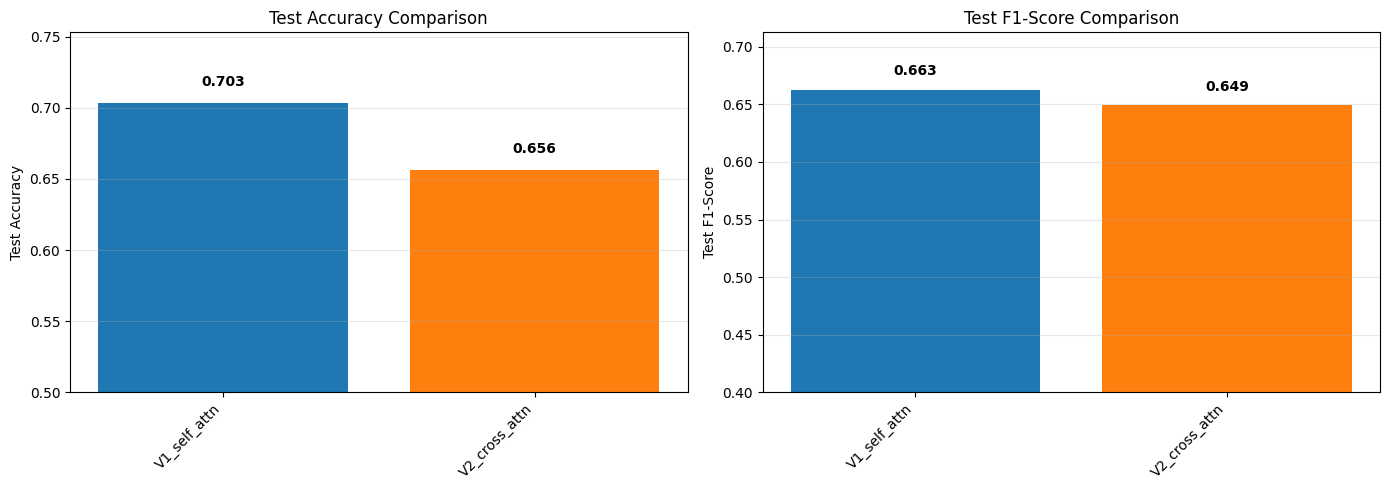

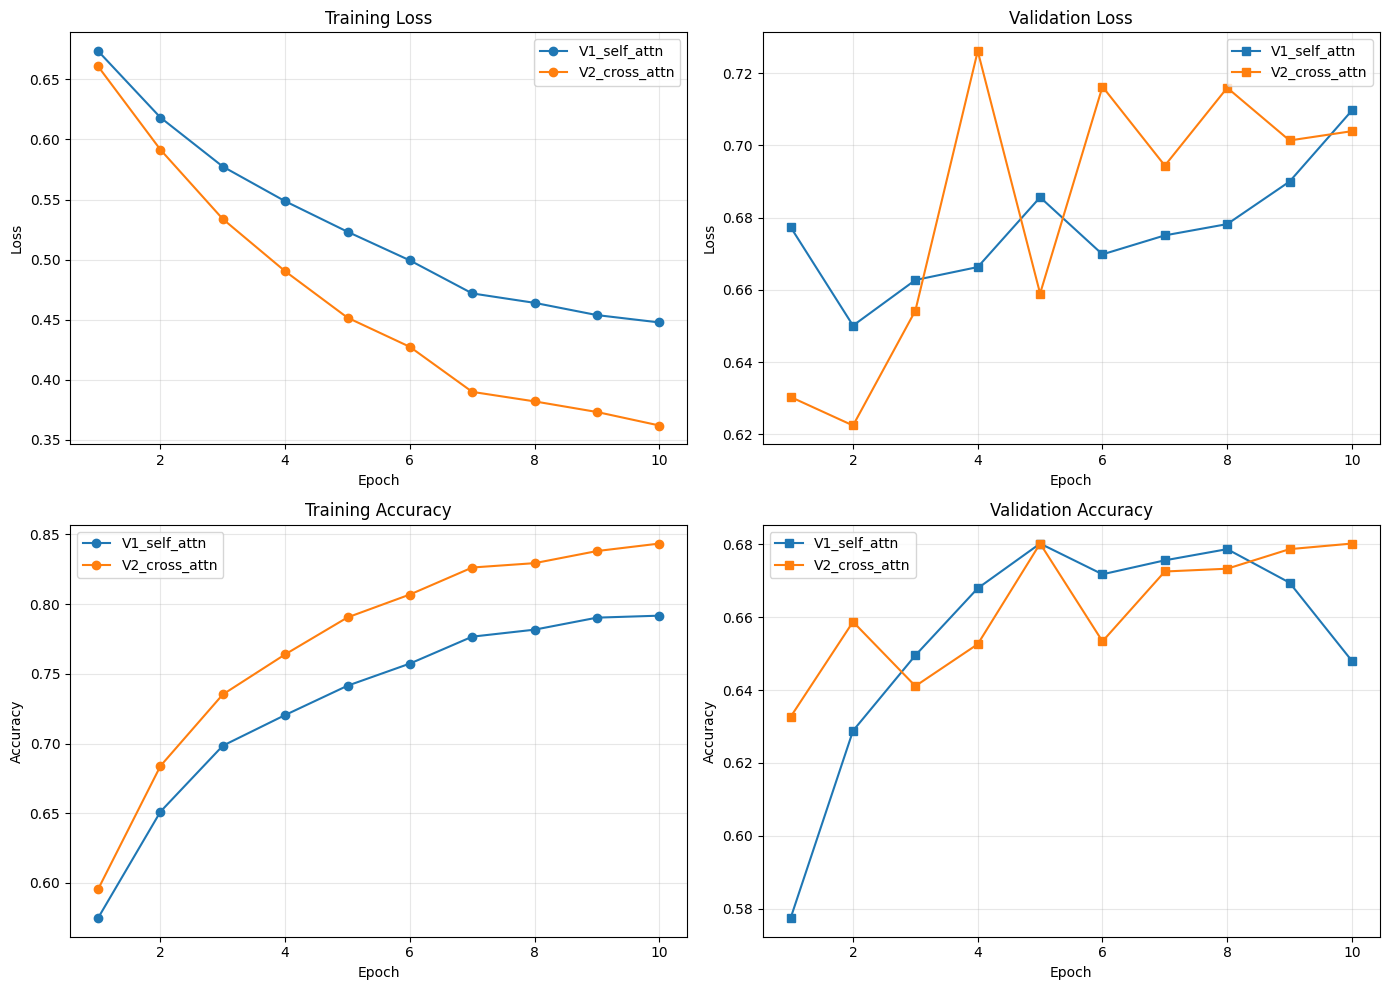


🏆 BEST PERFORMING MODEL:
   Variant: variant_1_self_attn
   Description: Concatenation + Self-Attention + Attention Pooling
   Test Accuracy: 0.7032
   Test F1-Score: 0.6627


In [92]:
%pip install tabulate

import matplotlib.pyplot as plt
from tabulate import tabulate

# 1. Summary Table
print("\n" + "="*70)
print("ABLATION STUDY RESULTS SUMMARY")
print("="*70 + "\n")

table_data = [['Variant', 'Description', 'Best Epoch', 'Val Acc', 'Test Acc', 'Test F1']]
for name, results in ablation_results.items():
    table_data.append([
        name.replace('variant_', 'V'),
        results['description'],
        results['best_epoch'],
        f"{results['best_val_acc']:.4f}",
        f"{results['test_acc']:.4f}",
        f"{results['test_f1']:.4f}"
    ])

print(tabulate(table_data, headers='firstrow', tablefmt='fancy_grid'))

# 2. Bar Charts - Test Performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

variants = list(ablation_results.keys())
test_accs = [ablation_results[v]['test_acc'] for v in variants]
test_f1s = [ablation_results[v]['test_f1'] for v in variants]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Accuracy comparison
ax1.bar(range(len(variants)), test_accs, color=colors[:len(variants)])
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Test Accuracy Comparison')
ax1.set_xticks(range(len(variants)))
ax1.set_xticklabels([v.replace('variant_', 'V') for v in variants], rotation=45, ha='right')
ax1.set_ylim(0.5, max(test_accs) + 0.05)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(test_accs):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# F1-Score comparison
ax2.bar(range(len(variants)), test_f1s, color=colors[:len(variants)])
ax2.set_ylabel('Test F1-Score')
ax2.set_title('Test F1-Score Comparison')
ax2.set_xticks(range(len(variants)))
ax2.set_xticklabels([v.replace('variant_', 'V') for v in variants], rotation=45, ha='right')
ax2.set_ylim(0.4, max(test_f1s) + 0.05)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(test_f1s):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('ablation_test_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Training Curves Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for variant_name, results in ablation_results.items():
    history = results['training_history']
    epochs = range(1, len(history['train_loss']) + 1)
    label = variant_name.replace('variant_', 'V')
    
    # Train loss
    axes[0, 0].plot(epochs, history['train_loss'], marker='o', label=label)
    # Val loss
    axes[0, 1].plot(epochs, history['val_loss'], marker='s', label=label)
    # Train acc
    axes[1, 0].plot(epochs, history['train_acc'], marker='o', label=label)
    # Val acc
    axes[1, 1].plot(epochs, history['val_acc'], marker='s', label=label)

axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_title('Training Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ablation_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Best Model Identification
best_variant = max(ablation_results.items(), key=lambda x: x[1]['test_acc'])
print(f"\n🏆 BEST PERFORMING MODEL:")
print(f"   Variant: {best_variant[0]}")
print(f"   Description: {best_variant[1]['description']}")
print(f"   Test Accuracy: {best_variant[1]['test_acc']:.4f}")
print(f"   Test F1-Score: {best_variant[1]['test_f1']:.4f}")